In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from scipy.stats import kruskal
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

- Vou criar o modelo utilizando apenas os dados que não tiveram ruptura pois os valores das vendas são mais próximos dos reais

In [2]:
df = pd.read_csv('../../data/processed/dados_features_Intermittent.csv')
df['dt_estoque'] = pd.to_datetime(df['dt_estoque'])
df = df[df['is_ruptura']==0]
df.drop(columns=['tipo_demanda', 'qtd_venda_interp', 'is_ruptura', 'qt_estoque'], inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,key_loja,cod_produto,dt_estoque,qtd_vendas,des_estado_franquia,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado_mean,qtd_vendas_media_1d,...,max_7d_30d_ratio_qt_estoque,max_7d_60d_ratio_qt_estoque,max_30d_60d_ratio_qt_estoque,min_1d_7d_ratio_qt_estoque,min_1d_30d_ratio_qt_estoque,min_1d_60d_ratio_qt_estoque,min_7d_30d_ratio_qt_estoque,min_7d_60d_ratio_qt_estoque,min_30d_60d_ratio_qt_estoque,day_of_the_week
0,3,48253,2024-01-01,0.0,GO,217.0,422944,731659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,77690,2024-01-01,0.0,GO,217.0,422944,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,82037,2024-01-01,0.0,GO,157293.0,483679,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,48253,2024-01-02,0.0,GO,217.0,422944,731659,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,3,77690,2024-01-02,1.0,GO,217.0,422944,390554,377.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Split Treino / Teste 

- Como Transformei a previsão de venda em um problema tabular vou realizar o split treino/teste de forma aleatória com 80% no treino e 20% no teste de cada combinação loja + produto

In [3]:
def split_grupo_robusto(grupo):
    n = len(grupo)
    
    if n == 1:
        # Apenas 1 registro → tudo no treino
        return pd.Series(['treino'], index=grupo.index)
    
    elif n == 2:
        # 50/50 para dois registros
        return pd.Series(['treino', 'teste'], index=grupo.sample(frac=1, random_state=42).index)
    
    else:
        # Split aleatório 80/20 para grupos maiores
        treino_idx, teste_idx = train_test_split(grupo.index, test_size=0.2, random_state=42)
        split = pd.Series('treino', index=grupo.index)
        split.loc[teste_idx] = 'teste'
        return split

df['grupo_split'] = df.groupby(['key_loja', 'cod_produto']).apply(split_grupo_robusto).reset_index(drop=True)

In [4]:
df_train = df[df['grupo_split'] == 'treino'].copy()
df_test = df[df['grupo_split'] == 'teste'].copy()

df_train.drop(columns=['grupo_split'], inplace=True)
df_test.drop(columns=['grupo_split'], inplace=True)

In [5]:
print("Treino:", df_train.shape)
print("Teste :", df_test.shape)

# Checar se todas as combinações estão em ambos
combos_treino = set(df_train[['key_loja', 'cod_produto']].apply(tuple, axis=1))
combos_teste  = set(df_test[['key_loja', 'cod_produto']].apply(tuple, axis=1))
print("Apenas no treino:", combos_treino - combos_teste)
print("Apenas no teste :", combos_teste - combos_treino)

Treino: (343, 130)
Teste : (88, 130)
Apenas no treino: set()
Apenas no teste : set()


In [6]:
list_feat_cat = ['des_estado_franquia', 'categoria_produto', 'sub_categoria_produto', 'linha_produto', 'day_of_the_week', 'key_loja', 'cod_produto']

list_feat_num = ['vlr_venda_tabelado_mean', 'qtd_vendas_media_1d', 'qtd_vendas_mediana_1d', 'qtd_vendas_max_1d', 'qtd_vendas_min_1d', 'qtd_vendas_media_7d', 'qtd_vendas_mediana_7d', 
                 'qtd_vendas_max_7d', 'qtd_vendas_min_7d', 'qtd_vendas_media_30d', 'qtd_vendas_mediana_30d', 'qtd_vendas_max_30d', 'qtd_vendas_min_30d', 'qtd_vendas_media_60d', 
                 'qtd_vendas_mediana_60d', 'qtd_vendas_max_60d', 'qtd_vendas_min_60d', 'media_1d_7d_ratio_qtd_vendas', 'media_1d_30d_ratio_qtd_vendas', 'media_1d_60d_ratio_qtd_vendas', 
                 'media_7d_30d_ratio_qtd_vendas', 'media_7d_60d_ratio_qtd_vendas', 'media_30d_60d_ratio_qtd_vendas', 'mediana_1d_7d_ratio_qtd_vendas', 'mediana_1d_30d_ratio_qtd_vendas', 
                 'mediana_1d_60d_ratio_qtd_vendas', 'mediana_7d_30d_ratio_qtd_vendas', 'mediana_7d_60d_ratio_qtd_vendas', 'mediana_30d_60d_ratio_qtd_vendas', 'max_1d_7d_ratio_qtd_vendas', 
                 'max_1d_30d_ratio_qtd_vendas', 'max_1d_60d_ratio_qtd_vendas', 'max_7d_30d_ratio_qtd_vendas', 'max_7d_60d_ratio_qtd_vendas', 'max_30d_60d_ratio_qtd_vendas', 
                 'min_1d_7d_ratio_qtd_vendas', 'min_1d_30d_ratio_qtd_vendas', 'min_1d_60d_ratio_qtd_vendas', 'min_7d_30d_ratio_qtd_vendas', 'min_7d_60d_ratio_qtd_vendas', 
                 'min_30d_60d_ratio_qtd_vendas', 'vlr_venda_tabelado_mean_media_1d', 'vlr_venda_tabelado_mean_mediana_1d', 'vlr_venda_tabelado_mean_max_1d', 'vlr_venda_tabelado_mean_min_1d', 
                 'vlr_venda_tabelado_mean_media_7d', 'vlr_venda_tabelado_mean_mediana_7d', 'vlr_venda_tabelado_mean_max_7d', 'vlr_venda_tabelado_mean_min_7d', 'vlr_venda_tabelado_mean_media_30d', 
                 'vlr_venda_tabelado_mean_mediana_30d', 'vlr_venda_tabelado_mean_max_30d', 'vlr_venda_tabelado_mean_min_30d', 'vlr_venda_tabelado_mean_media_60d', 
                 'vlr_venda_tabelado_mean_mediana_60d', 'vlr_venda_tabelado_mean_max_60d', 'vlr_venda_tabelado_mean_min_60d', 'media_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'media_1d_30d_ratio_vlr_venda_tabelado_mean', 'media_1d_60d_ratio_vlr_venda_tabelado_mean', 'media_7d_30d_ratio_vlr_venda_tabelado_mean', 
                 'media_7d_60d_ratio_vlr_venda_tabelado_mean', 'media_30d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'mediana_1d_30d_ratio_vlr_venda_tabelado_mean', 'mediana_1d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_7d_30d_ratio_vlr_venda_tabelado_mean', 
                 'mediana_7d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_30d_60d_ratio_vlr_venda_tabelado_mean', 'max_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'max_1d_30d_ratio_vlr_venda_tabelado_mean', 'max_1d_60d_ratio_vlr_venda_tabelado_mean', 'max_7d_30d_ratio_vlr_venda_tabelado_mean', 'max_7d_60d_ratio_vlr_venda_tabelado_mean', 
                 'max_30d_60d_ratio_vlr_venda_tabelado_mean', 'min_1d_7d_ratio_vlr_venda_tabelado_mean', 'min_1d_30d_ratio_vlr_venda_tabelado_mean', 'min_1d_60d_ratio_vlr_venda_tabelado_mean', 
                 'min_7d_30d_ratio_vlr_venda_tabelado_mean', 'min_7d_60d_ratio_vlr_venda_tabelado_mean', 'min_30d_60d_ratio_vlr_venda_tabelado_mean', 'qt_estoque_media_1d', 
                 'qt_estoque_mediana_1d', 'qt_estoque_max_1d', 'qt_estoque_min_1d', 'qt_estoque_media_7d', 'qt_estoque_mediana_7d', 'qt_estoque_max_7d', 'qt_estoque_min_7d', 
                 'qt_estoque_media_30d', 'qt_estoque_mediana_30d', 'qt_estoque_max_30d', 'qt_estoque_min_30d', 'qt_estoque_media_60d', 'qt_estoque_mediana_60d', 'qt_estoque_max_60d', 
                 'qt_estoque_min_60d', 'media_1d_7d_ratio_qt_estoque', 'media_1d_30d_ratio_qt_estoque', 'media_1d_60d_ratio_qt_estoque', 'media_7d_30d_ratio_qt_estoque', 
                 'media_7d_60d_ratio_qt_estoque', 'media_30d_60d_ratio_qt_estoque', 'mediana_1d_7d_ratio_qt_estoque', 'mediana_1d_30d_ratio_qt_estoque', 'mediana_1d_60d_ratio_qt_estoque', 
                 'mediana_7d_30d_ratio_qt_estoque', 'mediana_7d_60d_ratio_qt_estoque', 'mediana_30d_60d_ratio_qt_estoque', 'max_1d_7d_ratio_qt_estoque', 'max_1d_30d_ratio_qt_estoque', 
                 'max_1d_60d_ratio_qt_estoque', 'max_7d_30d_ratio_qt_estoque', 'max_7d_60d_ratio_qt_estoque', 'max_30d_60d_ratio_qt_estoque', 'min_1d_7d_ratio_qt_estoque', 
                 'min_1d_30d_ratio_qt_estoque', 'min_1d_60d_ratio_qt_estoque', 'min_7d_30d_ratio_qt_estoque', 'min_7d_60d_ratio_qt_estoque', 'min_30d_60d_ratio_qt_estoque']

list_no_feat = ['dt_estoque', 'qtd_vendas']

# Validando Nulos

In [7]:
def validate_features_null(df, list_feat):
    grouped = df.groupby(['key_loja', 'cod_produto'])

    # Avalia só nas features que você escolheu
    percent_nulos_por_grupo = grouped[list_feat].apply(lambda g: g.isnull().mean())
    
    # Média por feature
    percent_nulos_por_feature = percent_nulos_por_grupo.mean().sort_values(ascending=False) * 100
    
    # # Plotando
    # plt.figure(figsize=(12, max(6, len(percent_nulos_por_feature) * 0.5)))
    # ax = percent_nulos_por_feature.plot(kind='barh')
    
    # # Adiciona os valores ao lado das barras
    # for i, (valor, nome_coluna) in enumerate(zip(percent_nulos_por_feature, percent_nulos_por_feature.index)):
    #     ax.text(valor + 0.5, i, f"{valor:.1f}%", va='center', fontsize=10)
    
    # # Formatação do gráfico
    # plt.xlabel("% de valores nulos (média por loja + produto)")
    # plt.title("Porcentagem de Nulos por Feature Selecionada")
    # plt.gca().invert_yaxis()
    # plt.grid(True, axis='x')
    # plt.tight_layout()
    # plt.show()

    return percent_nulos_por_feature.to_frame().reset_index().rename(columns={0:'perct_nulo'})

In [8]:
df[list_feat_cat].isnull().sum()

des_estado_franquia      0
categoria_produto        0
sub_categoria_produto    0
linha_produto            0
day_of_the_week          0
key_loja                 0
cod_produto              0
dtype: int64

- Nenhuma Feature Categórica estava como nula

In [9]:
df_percent_nulos_por_feature = validate_features_null(df, list_feat_num)

- Irei Remover todas as features que tiverem >= 50% nulas. Pois se realizar imputação dos valores nulos irei adicionar viés desnecessário

In [10]:
list_feat_remove_null_num = df_percent_nulos_por_feature[df_percent_nulos_por_feature['perct_nulo']>=50]['index'].values
list_feat_restantes_null = df_percent_nulos_por_feature[df_percent_nulos_por_feature['perct_nulo']<50]['index'].values
list_feat_remove_null_num[0:5]

array(['mediana_1d_30d_ratio_qtd_vendas', 'min_1d_30d_ratio_qtd_vendas',
       'min_7d_60d_ratio_qtd_vendas', 'min_7d_30d_ratio_qtd_vendas',
       'min_1d_60d_ratio_qtd_vendas'], dtype=object)

In [11]:
list_feat_num = list(set(list_feat_num)-set(list_feat_remove_null_num))
list_feat_num[0:10]

['media_30d_60d_ratio_qt_estoque',
 'vlr_venda_tabelado_mean_media_60d',
 'media_7d_30d_ratio_qt_estoque',
 'qt_estoque_mediana_7d',
 'media_7d_60d_ratio_qt_estoque',
 'min_1d_7d_ratio_qt_estoque',
 'qtd_vendas_media_7d',
 'vlr_venda_tabelado_mean_min_60d',
 'qt_estoque_mediana_30d',
 'qt_estoque_media_7d']

- Para as Features que numéricas que restaram irei testar se a melhor solução será imputar valores ou imputar valores e marcar com flag de nulo:
    - Features de qtd_estoque e qtd_venda irei imputar 0
    - Features de preço irei imputar a mediana dessa coluna

In [14]:
y_train = df_train['qtd_vendas']
y_test = df_test['qtd_vendas']

# =====================
# Versão A e B: Imputar com regras
# =====================
X_train_a = df_train[list_feat_restantes_null]
X_test_a = df_test[list_feat_restantes_null]
X_train_b = X_train_a.copy()
X_test_b = X_test_a.copy()


# X_train_a.shape, X_test_a.shape , X_train_b.shape, X_test_b.shape, y_train.shape, y_test.shape
for col in list_feat_restantes_null:
    if 'qtd_estoque' in col or 'qtd_venda' in col:
        imput_value = 0
    elif 'vlr_venda_tabelado_mean' in col:
        imput_value = df_train[col].median()
    else:
        imput_value = df_train[col].median()

    # Imputação simples para B e C
    X_train_a[col] = X_train_a[col].fillna(imput_value)
    X_test_a[col] = X_test_a[col].fillna(imput_value)
    X_train_b[col] = X_train_b[col].fillna(imput_value)
    X_test_b[col] = X_test_b[col].fillna(imput_value)

    # Adicionar flag de nulo em B 
    X_train_b[f'is_null_{col}'] = df_train[col].isnull().astype(int)
    X_test_b[f'is_null_{col}'] = df_test[col].isnull().astype(int)

# =====================
# Modelos A e B
# =====================
model_a = LGBMRegressor(random_state=42, verbose=-1)
model_a.fit(X_train_a, y_train)
mae_a = mean_absolute_error(y_test, model_a.predict(X_test_a))

model_b = LGBMRegressor(random_state=42, verbose=-1)
model_b.fit(X_train_b, y_train)
mae_b = mean_absolute_error(y_test, model_b.predict(X_test_b))

# =====================
# Resultados
# =====================
print("MAE - A (imputação):", round(mae_a, 4))
print("MAE - B (Imputação + flag):", round(mae_b, 4))

MAE - A (imputação): 0.5298
MAE - B (Imputação + flag): 0.5455


- Então para esse modelo irei utilizar a imputação dos nulos apenas seguindo a regra acima 

In [15]:
for col in list_feat_num:
    if 'qtd_estoque' in col or 'qtd_venda' in col:
        imput_value = 0
    elif 'vlr_venda_tabelado_mean' in col:
        imput_value = df_train[col].median()
    else:
        imput_value = df_train[col].median()

    # Imputação simples para B e C
    df_train[col] = df_train[col].fillna(imput_value)
    df_test[col] = df_test[col].fillna(imput_value)

- Não vou fazer tratamento de valores nulos, pois irei utilizar o modelo Catboost que aceita valores NaN, qualquer tratamento que eu fizer pode gerar viés

# Avaliação Importancia das Features

## Categóricas

- As Features Categoricas irão receber um tratamento de one hot encoder para poderem serem utilizadas pelo modelo LGBM

In [16]:
from sklearn.preprocessing import OneHotEncoder

def transform_one_hot_encode(train, test, cols_categoricas):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Codificar as colunas categóricas
    train_codificadas = encoder.fit_transform(train[cols_categoricas])
    test_codificadas = encoder.transform(test[cols_categoricas])
    
    # Criar nomes das novas colunas
    nomes_colunas = encoder.get_feature_names_out(cols_categoricas)
    
    # DataFrame das variáveis codificadas
    df_train_oh = pd.DataFrame(train_codificadas, columns=nomes_colunas, index=train.index)
    df_test_oh = pd.DataFrame(test_codificadas, columns=nomes_colunas, index=test.index)

    # Concatenar com as colunas não categóricas
    df_train_restante = train.drop(columns=cols_categoricas)
    df_train_encoded = pd.concat([df_train_restante, df_train_oh], axis=1)

    df_test_restante = test.drop(columns=cols_categoricas)
    df_test_encoded = pd.concat([df_test_restante, df_test_oh], axis=1)

    return df_train_encoded, df_test_encoded, encoder, nomes_colunas

In [17]:
df_train_encoded, df_test_encoded, encoder, list_feat_cat_encoder = transform_one_hot_encode(df_train, df_test, list_feat_cat)

In [18]:
def avaliar_categorica_kruskal(df, col_categ, col_y):
    grupos = df[[col_categ, col_y]].dropna().groupby(col_categ)[col_y].apply(list)

    if len(grupos) < 2:
        return None, None  # Não tem comparação válida

    try:
        stat, pvalue = kruskal(*grupos)
        return stat, pvalue
    except Exception as e:
        print(f"Erro em {col_categ}: {e}")
        return None, None

In [19]:
resultados_cat = []

for col in list_feat_cat_encoder:  # ex: ['tipo_loja', 'categoria_produto']
    stat, p = avaliar_categorica_kruskal(df_train_encoded, col, 'qtd_vendas')
    if stat is not None:
        decisao = 'RELEVANTE' if p < 0.05 else 'DESCARTAR'
        resultados_cat.append((col, stat, p, decisao))

# Salvar em DataFrame
df_resultados_cat = pd.DataFrame(resultados_cat, columns=['feature', 'stat_H', 'p_value', 'decisao'])
df_resultados_cat

,feature,stat_H,p_value,decisao
0,des_estado_franquia_GO,0.707186,4.003795e-01,DESCARTAR
1,des_estado_franquia_MG,0.707186,4.003795e-01,DESCARTAR
2,categoria_produto_217.0,0.575309,4.481570e-01,DESCARTAR
3,categoria_produto_157293.0,0.575309,4.481570e-01,DESCARTAR
4,sub_categoria_produto_422944,0.575309,4.481570e-01,DESCARTAR
5,sub_categoria_produto_483679,0.575309,4.481570e-01,DESCARTAR
6,linha_produto_390554,0.004299,9.477210e-01,DESCARTAR
7,linha_produto_731659,0.004299,9.477210e-01,DESCARTAR
8,day_of_the_week_0,1.184085,2.765259e-01,DESCARTAR
9,day_of_the_week_1,1.983324,1.590406e-01,DESCARTAR


In [20]:
list_rel_cat = list(df_resultados_cat[df_resultados_cat['decisao']=='RELEVANTE']['feature'].values)
list_feat_cat_encoder = list(set(list_feat_cat_encoder).intersection(list_rel_cat))
len(list_feat_cat_encoder)

2

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def create_grid_barplots(df, cols_categoricas, col_y, n_cols=5):
    n = len(cols_categoricas)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_categoricas):
        ax = axes[i]
        # Agrupa e ordena decrescentemente
        df_aux = df.groupby(col)[col_y].sum().reset_index().sort_values(by=col_y, ascending=False)
        
        sns.barplot(x=col, y=col_y, data=df_aux, ax=ax, order=df_aux[col])
        # ax.set_title(f"{col} x {col_y}")
        ax.set_xlabel(col)
        ax.set_ylabel(col_y)

        # Adiciona os valores sobre as barras
        for bar, value in zip(ax.patches, df_aux[col_y]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2),
                    ha='center', va='bottom', color='black', fontsize=9)

        ax.tick_params(axis='x', rotation=45)

    # Remove gráficos extras (caso n < n_rows * n_cols)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [22]:
list_feat_cat_encoder[0:10]

['day_of_the_week_4', 'day_of_the_week_6']

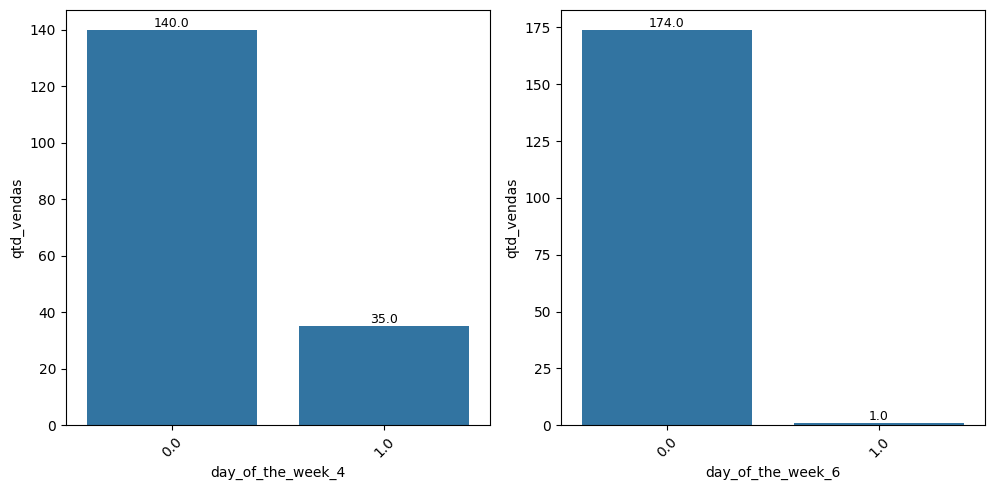

In [23]:
create_grid_barplots(df_train_encoded, list_feat_cat_encoder[0:10], 'qtd_vendas', n_cols=3)

## Numéricas

In [24]:
def classificar_percentil(df, list_features_num):
    df_copy = df.copy()
    colunas_sucesso = []
    colunas_falhas = []
    
    percentis = [0.05, 0.25, 0.5, 0.75, 0.95]
    rotulos = ['P05', 'P25', 'P50', 'P75', 'P95']
    
    for col in list_features_num:
        try:
            limites = df[col].quantile(percentis).values
            bins = [-np.inf] + list(limites) + [np.inf]
            labels = rotulos + ['>P95']
            df_copy[f'{col}_percentil'] = pd.cut(
                df[col], bins=bins, labels=labels, include_lowest=True, duplicates='drop'
            )
            colunas_sucesso.append(f'{col}_percentil')
        except ValueError as e:
            colunas_falhas = [].append(col)
            print(f"⚠️ Erro ao classificar '{col}': {e}")

    return df_copy, colunas_sucesso, colunas_falhas

In [25]:
def agrupar_extremos_percentil(df, cols_percentil):
    df_copy = df.copy()
    for col in cols_percentil:
        if '>P95' in df_copy[col].unique():
            df_copy[col] = df_copy[col].replace('>P95', 'P95')
    return df_copy

In [26]:
def identificar_features_nao_ordenadas(df, cols_percentil, col_y='qtd_vendas'):
    features_nao_ordenadas = []

    for col in cols_percentil:
        # Calcula a média de vendas por grupo de percentil
        medias = df.groupby(col)[col_y].mean().dropna()
        valores = medias.values

        # Verifica se está ordenado (crescente ou decrescente)
        if not (np.all(np.diff(valores) >= 0) or np.all(np.diff(valores) <= 0)):
            features_nao_ordenadas.append(col)

    return features_nao_ordenadas

In [27]:
df_com_percentis, colunas_sucesso, colunas_falhas = classificar_percentil(df_train_encoded, list_feat_num)
df_percentil_agrupado = agrupar_extremos_percentil(df_com_percentis, colunas_sucesso)
df_percentil_agrupado.head()

⚠️ Erro ao classificar 'min_1d_7d_ratio_qt_estoque': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'qtd_vendas_media_7d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'vlr_venda_tabelado_mean_min_60d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'qtd_vendas_max_7d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'max_1d_7d_ratio_qtd_vendas': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'min_7d_30d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'max_7d_30d_ratio_qt_estoque': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'qtd_vendas_media_1d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'vlr_venda_tabelado_mean_mediana_30d': Bin labels must be one fewer than the number of bin e

,dt_estoque,qtd_vendas,vlr_venda_tabelado_mean,qtd_vendas_media_1d,qtd_vendas_mediana_1d,qtd_vendas_max_1d,qtd_vendas_min_1d,qtd_vendas_media_7d,qtd_vendas_mediana_7d,qtd_vendas_max_7d,...,qt_estoque_media_1d_percentil,max_7d_60d_ratio_qt_estoque_percentil,qt_estoque_max_60d_percentil,media_7d_30d_ratio_vlr_venda_tabelado_mean_percentil,vlr_venda_tabelado_mean_media_30d_percentil,media_7d_60d_ratio_vlr_venda_tabelado_mean_percentil,qt_estoque_max_1d_percentil,media_1d_60d_ratio_vlr_venda_tabelado_mean_percentil,media_1d_60d_ratio_qt_estoque_percentil,max_1d_30d_ratio_qt_estoque_percentil
0,2024-01-01,0.0,178.9125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P50,P50,P50,P50,P50,P50,P50,P50,P50,P50
1,2024-01-01,0.0,178.9125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P50,P50,P50,P50,P50,P50,P50,P50,P50,P50
2,2024-01-01,0.0,178.9125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P50,P50,P50,P50,P50,P50,P50,P50,P50,P50
3,2024-01-02,0.0,178.9125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P75,P50,P50,P50,P50,P50,P75,P50,P50,P50
4,2024-01-02,1.0,377.4000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,P75,P50,P50,P50,P50,P50,P75,P50,P50,P50


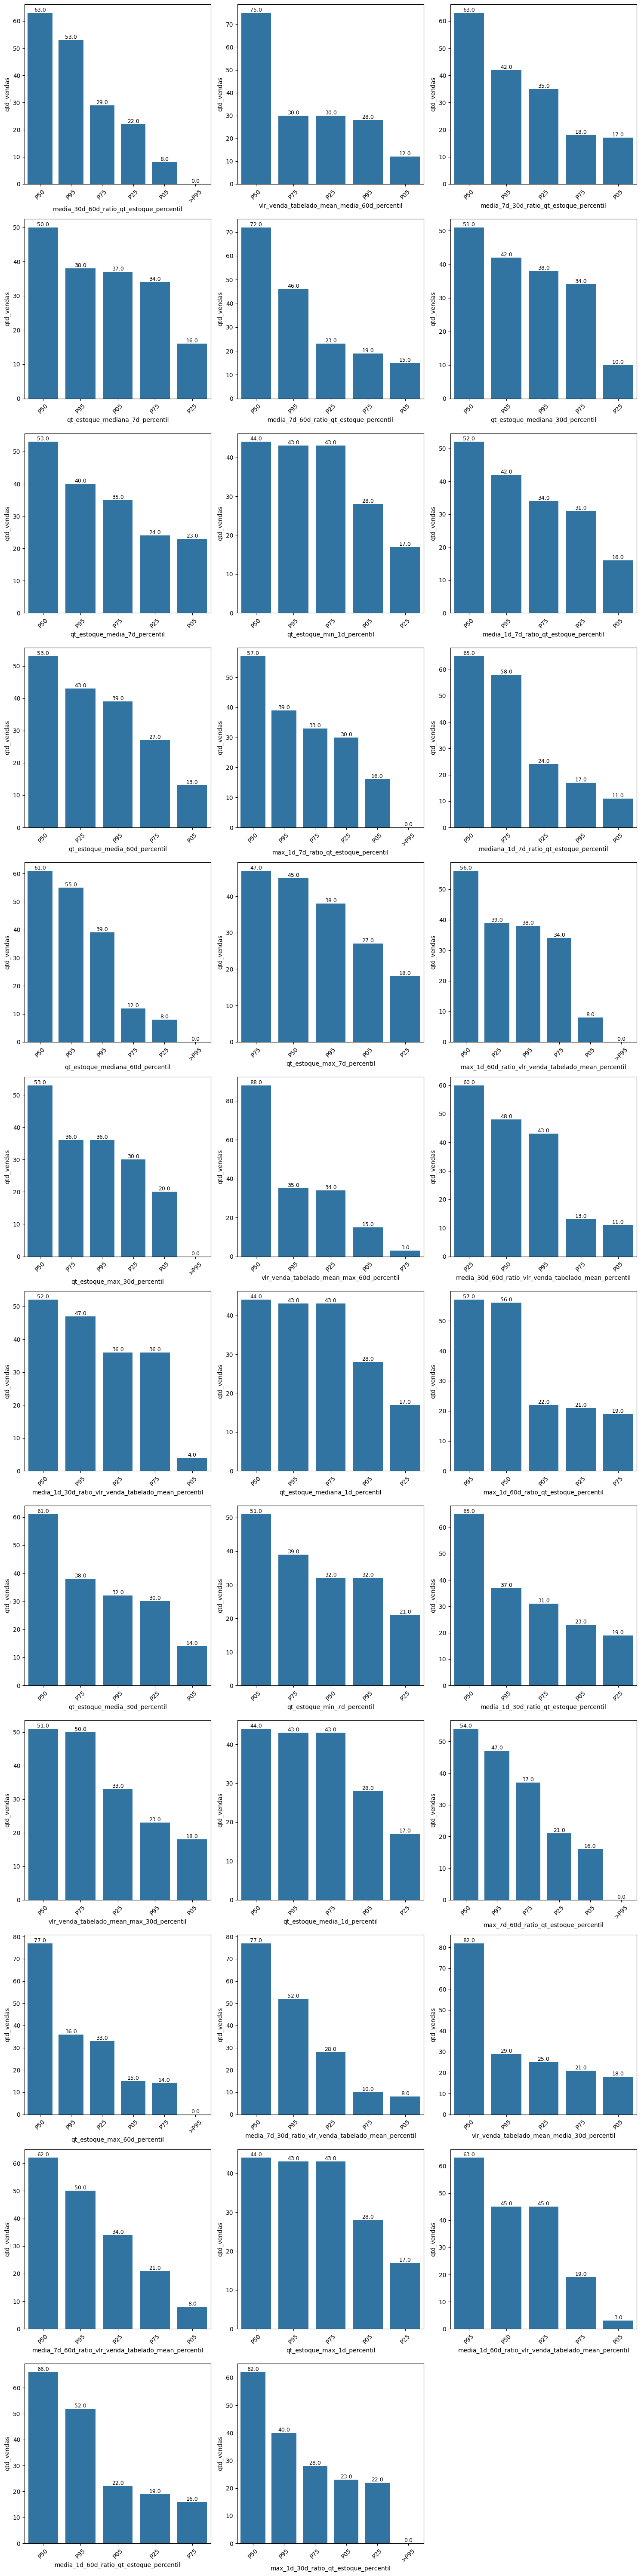

In [28]:
create_grid_barplots(df_percentil_agrupado, colunas_sucesso, 'qtd_vendas', n_cols=3)

In [29]:
def avaliar_feature_percentil_kruskal(df, col_percentil, col_y):
    # Agrupa por categoria da feature (ex: P05, P25, ...)
    grupos = df[[col_percentil, col_y]].dropna().groupby(col_percentil)[col_y].apply(list)
    
    if len(grupos) < 2:
        return None, None  # Não dá para testar com < 2 grupos

    # Aplica o teste de Kruskal-Wallis
    stat, pvalue = kruskal(*grupos)
    return stat, pvalue

In [30]:
resultados = []

for col in colunas_sucesso:  # ex: ['preco_percentil', 'estoque_percentil']
    stat, p = avaliar_feature_percentil_kruskal(df_percentil_agrupado, col, 'qtd_vendas')
    
    if stat is not None:
        resultados.append((str(col).replace('_percentil', ''), stat, p, 'RELEVANTE' if p < 0.05 else 'DESCARTAR'))

# Ordenar por p-valor
resultados = sorted(resultados, key=lambda x: x[2])

df_resultados = pd.DataFrame(resultados, columns=['feature', 'stat_H', 'p_value', 'decisao'])

# Exibir
df_resultados[df_resultados['decisao'] == 'DESCARTAR']

,feature,stat_H,p_value,decisao
0,media_30d_60d_ratio_qt_estoque,NaN,NaN,DESCARTAR
15,media_7d_60d_ratio_qt_estoque,9.072656,0.059309,DESCARTAR
16,media_30d_60d_ratio_vlr_venda_tabelado_mean,8.967483,0.061917,DESCARTAR
17,media_1d_7d_ratio_qt_estoque,8.356692,0.079352,DESCARTAR
18,qt_estoque_media_60d,8.232358,0.083428,DESCARTAR
19,media_7d_30d_ratio_vlr_venda_tabelado_mean,7.140575,0.128643,DESCARTAR
20,media_1d_30d_ratio_vlr_venda_tabelado_mean,5.878504,0.208407,DESCARTAR
21,vlr_venda_tabelado_mean_max_60d,5.812408,0.213603,DESCARTAR
22,vlr_venda_tabelado_mean_media_60d,5.462448,0.243050,DESCARTAR
23,vlr_venda_tabelado_mean_media_30d,5.083174,0.278869,DESCARTAR


In [31]:
list_feat_num = list(df_resultados[df_resultados['decisao'] == 'RELEVANTE']['feature'].values)
len(list_feat_num)

14

## Feature Selection por Modelo

In [37]:
import pandas as pd

def selecionar_features_por_importancia(X, y, top_k=None, threshold=None):
    model = LGBMRegressor(
        verbose=-1,
        random_state=42,
    )
    model.fit(X, y)

    importancias = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    # Selecionar por critério
    if top_k is not None:
        selecionadas = importancias.head(top_k)['feature'].tolist()
    elif threshold is not None:
        selecionadas = importancias[importancias['importance'] >= threshold]['feature'].tolist()
    else:
        selecionadas = importancias[importancias['importance'] > 0]['feature'].tolist()

    return selecionadas, importancias


In [38]:
list_feat = list_feat_cat_encoder.copy()
list_feat.extend(list_feat_num)
list_feat = list(set(list_feat))
len(list_feat), len(list_feat_cat_encoder), len(list_feat_num)

(16, 2, 14)

In [42]:
# Separar X e y
X = df_train_encoded[list_feat]
y = df_train_encoded['qtd_vendas']

# # Executar seleção
features_boas, ranking = selecionar_features_por_importancia(X, y)
# features_boas.append('key_loja')
# features_boas.append('cod_produto')

list_feat_final = list(set(features_boas))
print("Features selecionadas:", list_feat_final)
print("\nRanking completo:")
print(ranking)

Features selecionadas: ['qt_estoque_max_7d', 'day_of_the_week_4', 'qt_estoque_mediana_1d', 'media_1d_60d_ratio_vlr_venda_tabelado_mean', 'media_1d_30d_ratio_qt_estoque', 'media_1d_60d_ratio_qt_estoque', 'day_of_the_week_6', 'qt_estoque_media_7d', 'media_7d_30d_ratio_qt_estoque', 'max_1d_60d_ratio_qt_estoque', 'vlr_venda_tabelado_mean_max_30d', 'qt_estoque_mediana_7d', 'qt_estoque_media_30d']

Ranking completo:
                                       feature  importance
9                          qt_estoque_media_7d         148
10               media_7d_30d_ratio_qt_estoque         139
0                            qt_estoque_max_7d         131
8                media_1d_60d_ratio_qt_estoque         127
15                        qt_estoque_media_30d         120
6                media_1d_30d_ratio_qt_estoque         115
2                        qt_estoque_mediana_1d         109
3   media_1d_60d_ratio_vlr_venda_tabelado_mean          99
11                 max_1d_60d_ratio_qt_estoque         

In [43]:
list_feat_cat = list(set(list_feat_cat).intersection(list_feat_final))

In [44]:
len(list_feat_final)

13

# Treinamento Modelo

In [45]:
X_train = df_train_encoded[list_feat_final]
y_train = df_train_encoded['qtd_vendas']

X_test = df_test_encoded[list_feat_final]
y_test = df_test_encoded['qtd_vendas']

## Baseline

In [47]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) + 1e-8
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

In [49]:
# No treino: calcula a mediana por grupo
mediana_por_grupo = df_train.groupby(['key_loja', 'cod_produto'])['qtd_vendas'].median().reset_index()
mediana_por_grupo.rename(columns={'qtd_vendas':'qtd_vendas_pred'}, inplace=True)

X_train_pred = df_train.merge(mediana_por_grupo, on=['key_loja', 'cod_produto'], how='left')
X_train_pred.fillna(value={'qtd_vendas_pred':0})

X_test_pred = df_test.merge(mediana_por_grupo, on=['key_loja', 'cod_produto'], how='left')
X_test_pred.fillna(value={'qtd_vendas_pred':0})

mae_baseline_test = mean_absolute_error(y_test, X_test_pred['qtd_vendas_pred'])
smape_baseline_test = smape(y_test, X_test_pred['qtd_vendas_pred'])
print(f"MAE do baseline Teste: {mae_baseline_test:.2f} | SMAPE baseline Teste: {smape_baseline_test:.2f}")

mae_baseline_train = mean_absolute_error(y_train, X_train_pred['qtd_vendas_pred'])
smape_baseline_train = smape(y_train, X_train_pred['qtd_vendas_pred'])
print(f"MAE do baseline Train: {mae_baseline_train:.2f}  | SMAPE baseline Train: {smape_baseline_train:.2f}")

gap = (mae_baseline_test - mae_baseline_train) / mae_baseline_train
print(f"Gap relativo: {gap:.2%}")

MAE do baseline Teste: 0.56 | SMAPE baseline Teste: 75.00
MAE do baseline Train: 0.51  | SMAPE baseline Train: 71.72
Gap relativo: 9.14%


## Tunnig

In [50]:
import optuna
from optuna.samplers import TPESampler
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 7, 9),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    maes = []

    for train_idx, valid_idx in cv.split(X):
        X_train_fold, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = LGBMRegressor(**params, verbose=-1)
        model.fit(X_train_fold, y_train_fold)

        preds = model.predict(X_valid)
        mae = mean_absolute_error(y_valid, preds)
        maes.append(mae)

    return np.median(maes)

def rodar_otimizacao_bayesiana(X, y, n_trials=50):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    return study.best_trial, study.best_params, study

In [51]:
# Rode a otimização bayesiana
best_trial, best_params, study = rodar_otimizacao_bayesiana(X_train, y_train, n_trials=50)

print("Melhores hiperparâmetros encontrados:")
print(best_params)

[I 2025-05-05 16:01:58,826] A new study created in memory with name: no-name-9ec949b2-8a1d-4832-b7c9-ab6e41bdf981
[I 2025-05-05 16:01:58,923] Trial 0 finished with value: 0.6693844325291172 and parameters: {'n_estimators': 400, 'learning_rate': 0.19063571821788408, 'max_depth': 9, 'min_child_samples': 72, 'min_split_gain': 0.15601864044243652}. Best is trial 0 with value: 0.6693844325291172.
[I 2025-05-05 16:01:59,004] Trial 1 finished with value: 0.6420814925069904 and parameters: {'n_estimators': 224, 'learning_rate': 0.021035886311957897, 'max_depth': 9, 'min_child_samples': 72, 'min_split_gain': 0.7080725777960455}. Best is trial 1 with value: 0.6420814925069904.
[I 2025-05-05 16:01:59,061] Trial 2 finished with value: 0.6561716149370223 and parameters: {'n_estimators': 116, 'learning_rate': 0.19428287191077892, 'max_depth': 9, 'min_child_samples': 45, 'min_split_gain': 0.18182496720710062}. Best is trial 1 with value: 0.6420814925069904.
[I 2025-05-05 16:01:59,149] Trial 3 finishe

Melhores hiperparâmetros encontrados:
{'n_estimators': 465, 'learning_rate': 0.1540056487007661, 'max_depth': 8, 'min_child_samples': 30, 'min_split_gain': 0.10372772654542972}


- {'iterations': 685, 'learning_rate': 0.06422534481531783, 'depth': 8, 'l2_leaf_reg': 4.978107035094452, 'bagging_temperature': 0.7445378048598745, 'random_strength': 1.016900496982359}
    - MAE do baseline Teste: 1.89 | SMAPE baseline Teste: 100.81
    - MAE do baseline Train: 1.43  | SMAPE baseline Train: 98.42

In [52]:
model = LGBMRegressor(**best_params, verbose=-1, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_baseline_test = mean_absolute_error(y_test, y_test_pred)
smape_baseline_test = smape(y_test, y_test_pred)
print(f"MAE do baseline Teste: {mae_baseline_test:.2f} | SMAPE baseline Teste: {smape_baseline_test:.2f}")

mae_baseline_train = mean_absolute_error(y_train, y_train_pred)
smape_baseline_train = smape(y_train, y_train_pred)
print(f"MAE do baseline Train: {mae_baseline_train:.2f}  | SMAPE baseline Train: {smape_baseline_train:.2f}")

gap = (mae_baseline_test - mae_baseline_train) / mae_baseline_train
print(f"Gap relativo: {gap:.2%}")

MAE do baseline Teste: 0.58 | SMAPE baseline Teste: 151.34
MAE do baseline Train: 0.37  | SMAPE baseline Train: 143.72
Gap relativo: 56.05%


In [ ]:
optuna.visualization.plot_optimization_history(study).show()

In [ ]:
optuna.visualization.plot_param_importances(study).show()

In [ ]:
optuna.visualization.plot_slice(study).show()